# Classification_NN.ipynb

### This notebook contains the feature generation, supervised machine learning and validation for automatic classification of Tweets.

Author: Erik Puijk <br>
Date  : April 18, 2022

In [7]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /home/erik/anaconda3/lib/python3.8/site-packages (1.0.2)
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Before you run this: install tensorflow
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import json, csv, math, random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
from sklearn import svm
import pyperclip as pc

In [2]:
Encoder = LabelEncoder()
plt.style.use('ggplot')

In [3]:
#https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [4]:
def read_tweets(path):
    """ Read the Tweets from a given text file and return in JSON-format. """
    
    content = ""
    
    try:
        with open(path, 'r') as f:
            content = json.loads(f.read())
    except IOError:
        print("I/O error")
        
    #print("Total Tweets read: %s\n" % (len(content)))

    return content

In [5]:
def write_tweets(tweets_w, path):
    """ Write obtained Tweets to a text file in JSON-format. """
    
    try:
        with open(path, 'w') as f:
            json.dump(tweets_w, f)
    except IOError:
        print("I/O error")

In [6]:
def stats_count(cat):
    """ Count the occurrences of each category in a list of categories. """
    
    occurrences = [[x,cat.count(x)] for x in set(cat)]
    
    print('Number of training data')
    
    for occ in occurrences:
        print('%s: %s' % (occ[0], occ[1]))
        
    print('')

In [7]:
def calc_avg_scores(scores, cats, k):
    """ Calculate an average score given a list of scores. """
    
    scores_avg = []
    
    # If a list of lists of scores is given, calculate the average per label
    if isinstance(scores[0], list): 
        
        for i in range(len(cats)):

            total = 0

            for j in range(k):
                total += scores[j][i]

            scores_avg.append(total / k)
            
    # If a list of average (f1) scores is given, just return that list
    else:
        return scores

    return scores_avg

In [8]:
def keysort(x):
    
    #return sum(x[1]) / len(x[1])
    return min(x[1])

In [33]:
# Taken from https://realpython.com/python-keras-text-classification/
def plot_history(history):
    acc = history.history['f1_m']
    val_acc = history.history['val_f1_m']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training f1')
    plt.plot(x, val_acc, 'r', label='Validation f1')
    plt.title('Training and validation f1')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [34]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [35]:
def ml(X_train, y_train, X_test, y_test, v_type, alg, ngram_min, ngram_max, min_df, max_df, max_features, cats):
    
    # Select appropriate vectorizer
    if v_type == 'count':
        vectorizer = CountVectorizer(analyzer='word', ngram_range=(ngram_min, ngram_max), min_df=min_df, \
                                     max_df=max_df, max_features=max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=(ngram_min, ngram_max), min_df=min_df, max_df=max_df, \
                                     max_features=max_features, sublinear_tf=True)
    
    # Convert tokens to vectors and transform to arrays
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()
    
    # Convert labels to categoricals for Keras use
    y_train_cat = to_categorical(y_train, len(cats))
    y_test_cat = to_categorical(y_test, len(cats))
    
    # Create and fit NN
    model = Sequential()
    model.add(layers.Dense(10, input_dim=X_train[()].shape[1], activation='relu'))
    model.add(layers.Dense(len(cats), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])
    
    history = model.fit(X_train, y_train_cat, epochs=50, validation_data=(X_test, y_test_cat), verbose=False)
    plot_history(history)

    loss_train, acc_train, f1_train = model.evaluate(X_train, y_train_cat, verbose=False)
    loss_test, acc_test, f1_test = model.evaluate(X_test, y_test_cat, verbose=False)
    
    return list(np.argmax(model(X_test), axis=1))

In [36]:
def cross_val(v_type, X, y, ngram_min, ngram_max, min_df, max_df, max_features, cats, alg):
    """ Perform the count/tfidf vectorization on the test set and run 5-fold cross validation on the test set
        to compare the results. """
    
    scores = []
    k = 3 #test with lower k's, maybe 3, 4
        
    # Run cross-validation and calculate scores
    kf = KFold(n_splits=k)
    for train, valid in kf.split(X, y):
        X_train = [X[i] for i in train]
        y_train = [y[i] for i in train]
        X_valid = [X[i] for i in valid]
        y_valid = [y[i] for i in valid]
        
        y_pred = ml(X_train, y_train, X_valid, y_valid, v_type, alg, ngram_min, ngram_max, min_df, max_df, \
                  max_features, cats)
        
        scores.append(f1_score(y_valid, y_pred, average='micro', zero_division=0))
        #scores.append(list(f1_score(y_valid, y_pred, average=None, zero_division=0)))
    
    # Return the configuration of the model together with the average of scores
    return [[ngram_min, ngram_max, min_df, max_df, max_features], calc_avg_scores(scores, cats, k)]

In [37]:
def test_configurations(v_type, test_validation, tweets, labels, alg):
    """ Test different configurations for different models and compare the micro-f1 scores to select the best
        model. """
    
    cats = list(set(labels))
    
    # Define model parameters according to which categorization
    if len(cats) == 3:
        # Content
        ngrams = [1]#[1, 2]
        min_dfs = [1]#[1, 2, 3]
        max_dfs = [1.0]#[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
        max_features = [None]
    else:
        # Activation
        ngrams = [1, 2]
        min_dfs = [1, 2, 3, 4, 5] #[2, 3, 4]
        max_dfs = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
        max_features = [None, 3000]
    
    # Split data set into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.3, random_state=0)
        
    #stats_count(list(y_train))

    # Encode labels
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)
    
    scores = []
    i = 0
    i_max = (len(ngrams)**2 - math.factorial(len(ngrams)-1)) * len(min_dfs) * len(max_dfs) * len(max_features)
    
    # Combine each parameter and run the model with cross validation
    for ngram_min in ngrams:
        for ngram_max in ngrams:
            if ngram_min > ngram_max:
                continue
            for min_df in min_dfs:
                for max_df in max_dfs:
                    for max_feature in max_features:
                        i += 1
                        #print('Progress: %s/%s configurations' % (i, i_max), end='\r')
                        
                        # Call the function for the model and append the score
                        scores.append(cross_val(v_type, X_train, y_train, ngram_min, ngram_max, min_df, \
                                                max_df, max_feature, cats, alg))
    
    # Sort the scores descending and print them
    scores.sort(key=keysort, reverse=True)
    
    prnt = ''
    
    if test_validation:
        # Select the best configurations
        best_score = min(scores[0][1])
        best_configs = []
        for score in scores:
            #if min(score[1]) == best_score:
            best_configs.append(score)

        # Use the best configurations to validate model on the test set
        for config, score in best_configs:
            prnt += (str([config, score]) + '\n')
            
            pred = ml(X_train, y_train, X_test, y_test, v_type, alg, config[0], config[1], config[2], config[3], \
                      config[4], cats)

            prnt += (classification_report(y_test, pred, target_names=Encoder.inverse_transform(list(set(y_test))), \
                                           zero_division=0))

    print(prnt)
    #pc.copy(prnt)
    #print('Result copied')
    #print(scores)

[[1, 1, 1, 1.0, None], [0.7614678899082569, 0.8073394495412844, 0.8518518518518519]]
              precision    recall  f1-score   support

         CAM       0.81      0.78      0.79        32
         POL       0.85      0.97      0.91        95
         SOC       1.00      0.08      0.14        13

    accuracy                           0.84       140
   macro avg       0.89      0.61      0.61       140
weighted avg       0.86      0.84      0.81       140



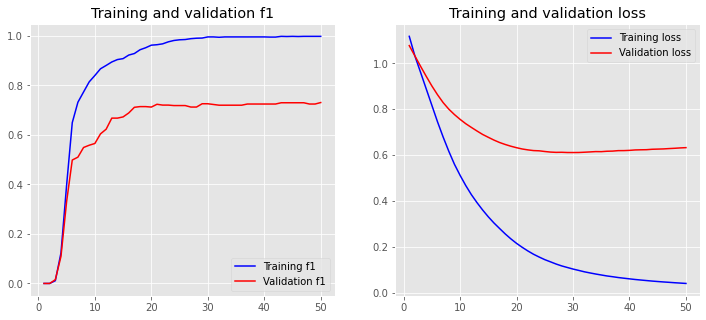

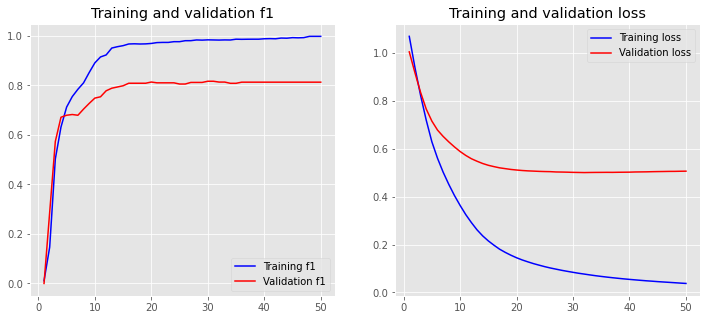

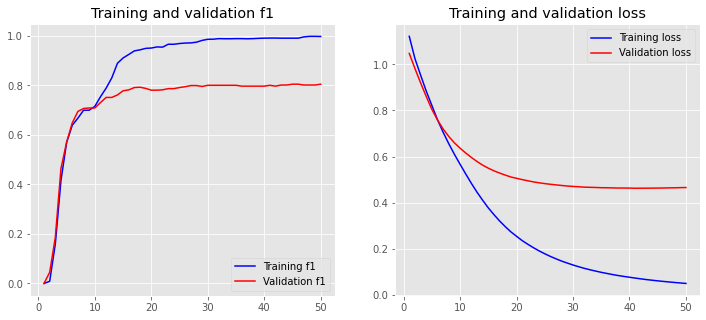

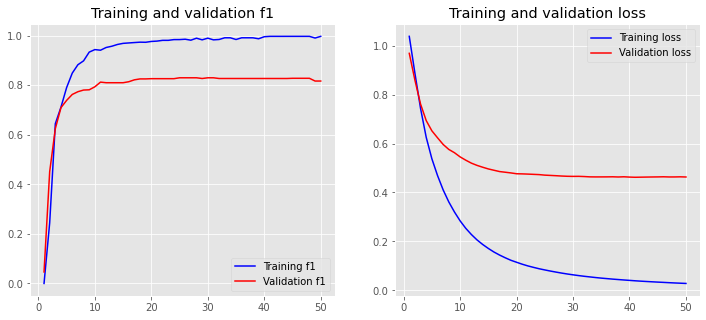

In [38]:
tweets_con = read_tweets('source/tweets_all_preprocessed_no_stopwords.txt')
tweets_act = read_tweets('source/tweets_all_preprocessed_exc_stopwords.txt')

tweets_con_gs = [tweet for tweet in tweets_con if tweet['memo'] == 'gold_standard']
tweets_act_gs = [tweet for tweet in tweets_act if tweet['memo'] == 'gold_standard']

tweets_con_text = [tweet['text'] for tweet in tweets_con_gs]
tweets_act_text = [tweet['text'] for tweet in tweets_act_gs]

labels_con = [tweet['cat_con'] for tweet in tweets_con_gs]
labels_act = [tweet['cat_act'] for tweet in tweets_act_gs]

test_configurations('count', True, tweets_con_text, labels_con, 'linear_svc')
#test_configurations('tfidf', True, tweets_act_text, labels_act, 'svc')
#print('Progress: %s/%s runs' % (i, i_max), end='\r')